#Problem 9: Image classification with neural networks#

In this problem, you will train a neural network to classify satellite images. In the data/EuroSAT_RGB directory, you will find 11 subdirectories, each corresponding to a different class of land or land use: e.g. industrial, crops, rivers, forest, etc. Within each subdirectory, you will find examples in .jpg format of each type. (Thus the name of the directory in which the image lives is the class label.)

Your job is to set up a neural network that can classify the images as accurately as possible. Use an 80/20 train test split. Summarize your model and its accuracy in any way you see fit, but make you include at a minimum the following elements:

> - overall test-set accuracy, measured however you think is appropriate
> - show some of the example images from the test set, together with your model's predicted classes.
> - a confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).

I strongly recommend the use of PyTorch in a Jupyter notebook for this problem; look into PyTorch's ImageFolder data set class, which will streamline things considerably.

Step 1: Importing required libraries 

In [116]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import tqdm
import os
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics



Step 2: Reading all images, scaling images and creating labels

In [57]:
#Path to image folders
path = 'EuroSAT_RGB'
dir_list = os.listdir(path)

#initialize image and labels lists
images = []
labels = []

#define image transformation: 1. to tensor and 2. normalized
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# for every directory read all images and label them
for label in dir_list:
    path = 'EuroSAT_RGB/'+ label + '/'
    dir_list = os.listdir(path)

    #store each image and label in a list
    for file in dir_list:
        img = Image.open(path+file)
        img_tensor = transform(img)
        images.append(img_tensor)
        labels.append(label)

Step 3: Encode labels, split data into training and test

In [91]:

#Create a dictionary of index for each label
label_to_index = {}
label_to_index = {label: index for index, label in enumerate(set(labels))}
index_to_label = {index: label for label, index in label_to_index.items()}


#Convert string labels in our data to indexes
label_indices = []
for label in labels:
    label_indices.append(label_to_index[label])

#Converted to array to use train_test_split
data_array = np.array(images)
labels_array = np.array(label_indices)

#Randomly split data and labels to training and testing (20% test data)
train_data, test_data, train_labels, test_labels = train_test_split(data_array, labels_array, test_size=0.2, random_state=1)


/var/folders/hg/kqg69xz568l28vnvcx6x09hh0000gn/T/ipykernel_47485/2831960512.py:13: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_array = np.array(images)
/var/folders/hg/kqg69xz568l28vnvcx6x09hh0000gn/T/ipykernel_47485/2831960512.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_array = np.array(images)


Step 4: Combine images and labels to create dataloaders

In [23]:
# initialize train,test tuple list
train_data_tuple = []
test_data_tuple = []

# fill tuple list with (image,label) - training
for i in range(len(train_data)):
    train_data_tuple.append(tuple([train_data[i],train_labels[i]]))

# fill tuple list with (image,label) - test
for i in range(len(test_data)):
    test_data_tuple.append(tuple([test_data[i],test_labels[i]]))

# Create dataloader so we can utilize parallel processing
trainloader = torch.utils.data.DataLoader(train_data_tuple, batch_size=64,shuffle=True, num_workers=2 )
testloader = torch.utils.data.DataLoader(test_data_tuple, batch_size=64,shuffle=True, num_workers=2 )


Step 5: Validate images and labels

Sample Training Data: 


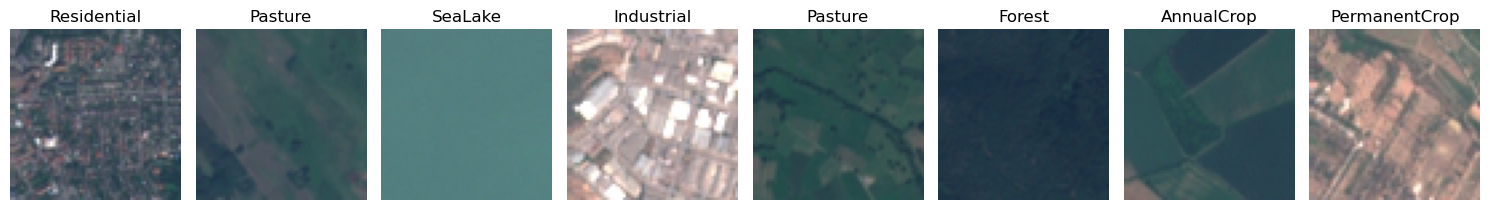

Sample Testing Data: 


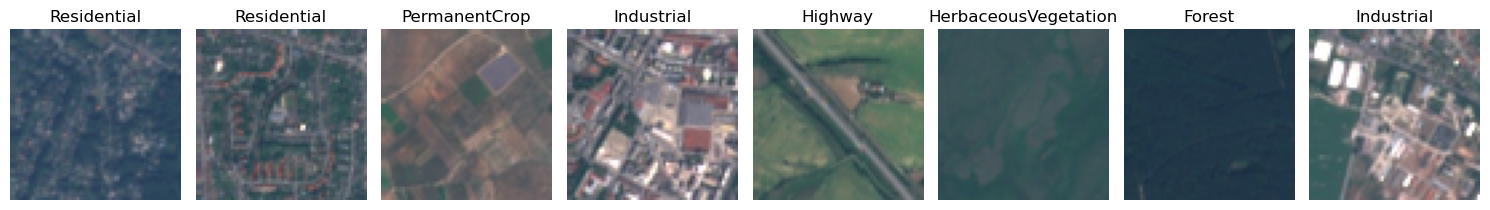

In [109]:
# for training

fig, axes = plt.subplots(1, 8, figsize=(15, 3))  # Create a single row with 5 subplots

print('Sample Training Data: ')
for i in range(8):
    j=np.random.randint(0, high=21599)
    axes[i].imshow(((train_data[j] * 0.5) + 0.5).permute(1, 2, 0)) #Multiplied by 0.5 and added 0.5 to get original image
    axes[i].set_title(index_to_label[train_labels[j]])
    axes[i].axis('off')  

plt.tight_layout()  
plt.show()

# for testing

fig, axes = plt.subplots(1, 8, figsize=(15, 3))  # Create a single row with 5 subplots

print('Sample Testing Data: ')
for i in range(8):
    j=np.random.randint(0, high=5399)
    axes[i].imshow(((test_data[j] * 0.5) + 0.5).permute(1, 2, 0)) #Multiplied by 0.5 and added 0.5 to get original image
    axes[i].set_title(index_to_label[test_labels[j]])
    axes[i].axis('off')  

plt.tight_layout()  
plt.show()

Step 6: Define Neural Net

In [113]:
# initializing net class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv4 = nn.Conv2d(64, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)  # Each channel gets zeroed out independently on each forward call with probability p
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(50176, 128) 
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

#to use gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Step 7: Train the Neural Net on training data

In [114]:
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad()  # Clear gradients
        output = net(data)    # Forward pass
        loss = criterion(output, target)  # Calculate loss
        loss.backward()       # Backpropagation
        optimizer.step()      # Update model parameters
        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")



/Users/uditdhand/anaconda3/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1, Loss: 58.65774980932474
Epoch 2, Loss: 40.013331323862076
Epoch 3, Loss: 33.156654827296734
Epoch 4, Loss: 30.07347336784005
Epoch 5, Loss: 26.475591331720352


Step 8: Check against testing set

In [115]:
# initialize predicted and actual labels list
predicted_labels = []
actual_labels = []

# Predictions on test data
with torch.no_grad():
        net.eval()  # Set the model to evaluation mode
        for val_data, val_target in testloader:
            val_output = net(val_data)
            _, predicted = torch.max(val_output, 1)
            predicted_labels.extend(predicted.tolist())
            actual_labels.extend(val_target.tolist())



Step 9: Calculate Accuracy, check predictions and confusion matrix

The accuracy of this neural network is: 0.8011111111111111
Sample Testing Data: 


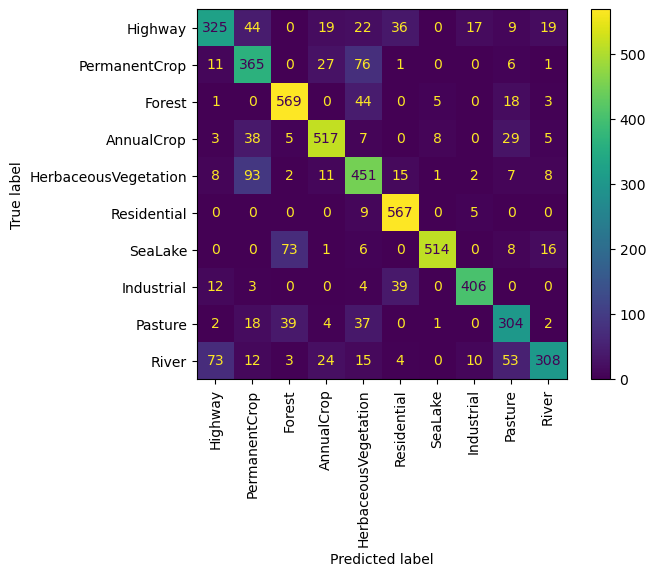

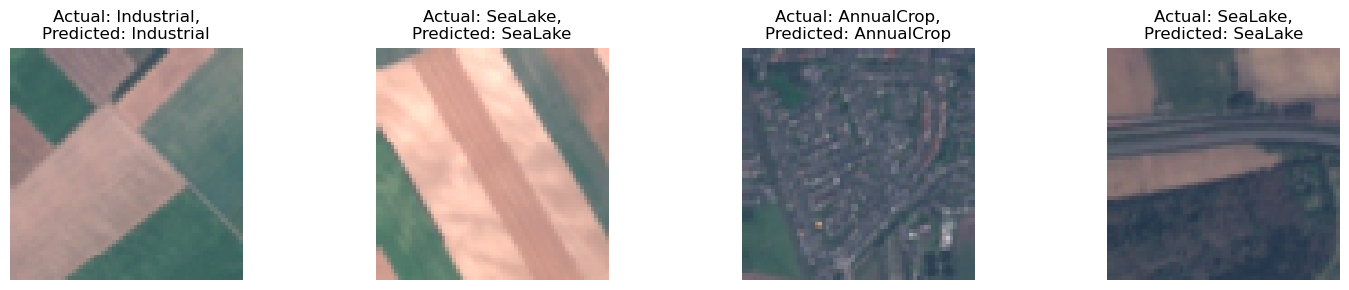

In [121]:
# calculate model accuracy
accuracy = metrics.accuracy_score(y_pred=(predicted_labels),y_true=actual_labels)
print('The accuracy of this neural network is: ' + str(accuracy))

# create confusion matrix
conf_matrix = metrics.confusion_matrix(y_pred=(predicted_labels),y_true=actual_labels)

# display confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=label_to_index.keys())
disp.plot(xticks_rotation='vertical')

# display some predictions on test
fig, axes = plt.subplots(1, 4, figsize=(15, 3))  # Create a single row with 5 subplots

print('Sample Testing Data: ')
for i in range(4):
    j=np.random.randint(0, high=5399)
    axes[i].imshow(((test_data[j] * 0.5) + 0.5).permute(1, 2, 0)) #Multiplied by 0.5 and added 0.5 to get original image
    axes[i].set_title('Actual: '+index_to_label[actual_labels[j]]+',\nPredicted: '+index_to_label[predicted_labels[j]])
    axes[i].axis('off')

plt.tight_layout()  
plt.show()